# Cell Division 

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view

from tyssue.draw.plt_draw import sheet_view
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division
from tyssue.core.objects import get_opposite
from tyssue.core.generation import create_anchors

from tyssue.io import hdf5
from tyssue.stores import load_datasets

In [2]:
# h5store = 'before_apoptosis.hf5'
h5store = 'small_hexagonal.hf5'

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
datasets['edge'] = datasets['edge'][['srce', 'trgt', 'face']]
datasets['face'] = datasets['face'][['x', 'y', 'z', 'is_alive']]
datasets['vert'] = datasets['vert'][['x', 'y', 'z']]

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

live_edges = sheet.upcast_face(sheet.face_df.is_alive)

# ## Boundary conditions
sheet.vert_df.is_active = 1


# ## Remove dead cells at boundary
boundary_cells = sheet.face_df[sheet.face_df.is_alive==0].index
for cell in boundary_cells:
    remove_face(sheet, cell)

sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)


create_anchors(sheet)
anchor_tension = 0.6

nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
nondim_specs['edge']['anchor_tension'] = anchor_tension
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

geom.update_all(sheet)


In [3]:
sheet.Nf, sheet.Ne, sheet.Nv

(56, 240, 96)

In [4]:
res = solver.find_energy_min(sheet, geom, model)


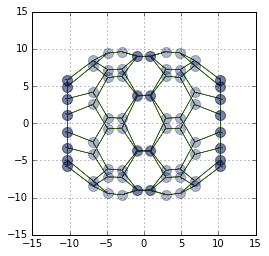

In [5]:
fig, ax = sheet_view(sheet, ['z', 'x'])

In [6]:
sheet.Nf, sheet.Ne, sheet.Nv

(56, 240, 96)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


True


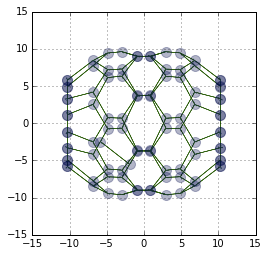

In [8]:
daughter = cell_division(sheet, 16, geom, angle=0)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = sheet_view(sheet, ['z', 'x'])